# Demo for the 3-Component Biological Condensate Benchmark

In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from phaseGP.models import PhaseGP, PhaseTransferGP
from phaseGP.utils import brute_sample_new_points, get_grid, set_seeds
from phaseGP.visualization import phase_diagram_plot, phase_diagram_probability_plot, phase_acquisition_plot

from ground_truth.flory_phase import flory_true_phase

def swapper(phase_diagram):
    phase_diagram[phase_diagram==2] = 1
    phase_diagram[phase_diagram==1] = 3
    phase_diagram[phase_diagram==0] = 1
    phase_diagram[phase_diagram==3] = 0
    return phase_diagram

def grid_mask(grid):
    mask = grid[:,0] + grid[:,1] < 1
    return grid[mask]

def remove_invalid_points(ax):
    outbounds_x = [0, 1, 1, 0]  # Triangle outbounds fo diagram
    outbounds_y = [1, 0, 1, 1]

    ax.fill(outbounds_x, outbounds_y, color='white')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    return ax


In [4]:
#Low to high source -> [0.6, 0.45, 0.3] | target -> 0.75
source_ionic_strengths = [0.6, 0.45, 0.3]
target_ionic_strength = 0.75

set_seeds(50)

# Source Tasks

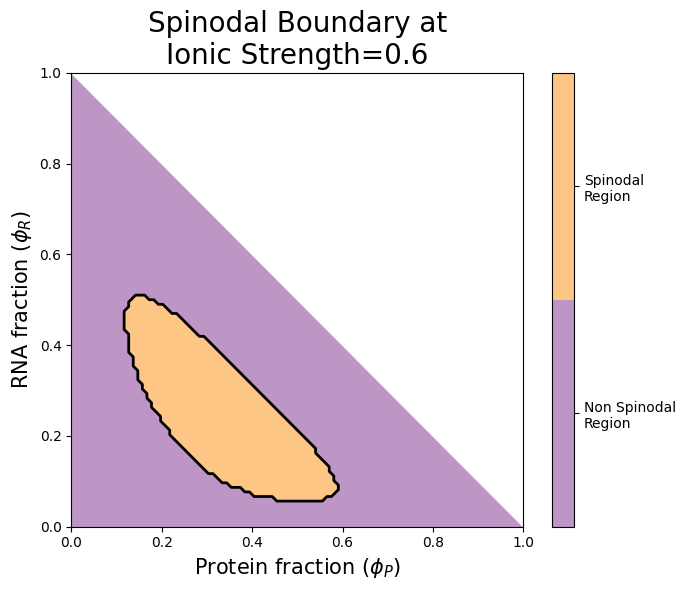

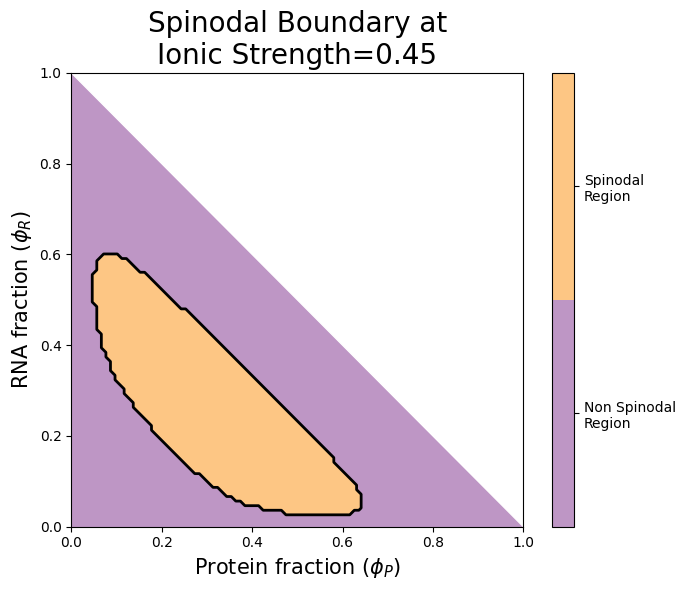

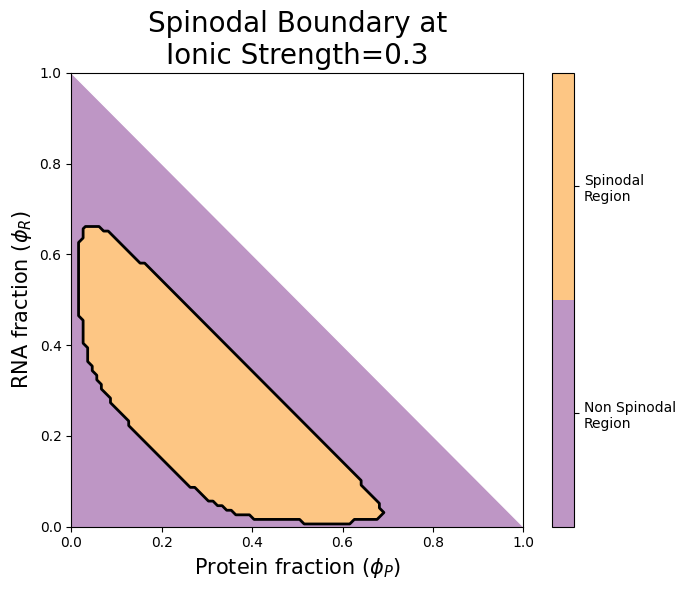

In [5]:
grid_points, x1, x2 = get_grid(x_min=0.001, x_max=0.999, grid_size=100, return_coordinates=True)

for i, ionic_strength in enumerate(source_ionic_strengths):
    phase_diagram = flory_true_phase(grid_points, ionic_strength).reshape(100,100)
    phase_diagram = swapper(phase_diagram)
    fig, ax = phase_diagram_plot(phase_diagram, x1, x2, plot_boundary=True, 
                       phase_labels=["Non Spinodal\nRegion","Spinodal\nRegion"], title=f"Spinodal Boundary at\nIonic Strength={ionic_strength}",
                       xlabel=r"Protein fraction $(\phi_P)$", ylabel=r"RNA fraction $(\phi_R)$")
    ax = remove_invalid_points(ax)

# Target Task

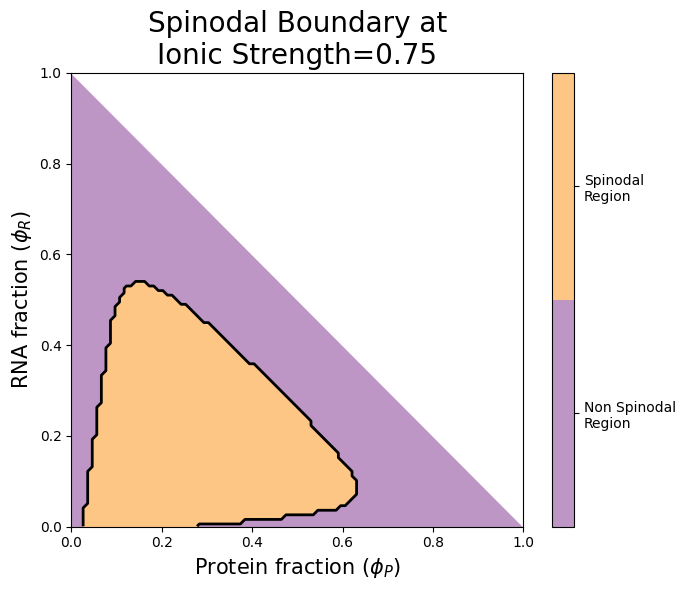

In [6]:
grid_points, x1, x2 = get_grid(x_min=0.001, x_max=0.999, grid_size=100, return_coordinates=True)


phase_diagram = flory_true_phase(grid_points, target_ionic_strength).reshape(100,100)
phase_diagram = swapper(phase_diagram)
fig, ax = phase_diagram_plot(phase_diagram, x1, x2, plot_boundary=True, 
                    phase_labels=["Non Spinodal\nRegion","Spinodal\nRegion"], title=f"Spinodal Boundary at\nIonic Strength={target_ionic_strength}",
                    xlabel=r"Protein fraction $(\phi_P)$", ylabel=r"RNA fraction $(\phi_R)$")
ax = remove_invalid_points(ax)

# Run Active learning on source tasks

In [7]:
def source_active_learning_loop(ionic_strength, n_points=50, n_initial_points = 10, candidate_size = 30, test_size = 100):
    candidate_grid = get_grid(0.001,0.999, candidate_size)
    candidate_grid = grid_mask(candidate_grid)

    indices = np.random.choice(len(candidate_grid), size=n_initial_points, replace=False)
    train_x = candidate_grid[indices]
    train_y = flory_true_phase(train_x, ionic_strength=ionic_strength )


    test_grid = get_grid(0.001,0.999, test_size)
    test_grid = grid_mask(test_grid)
    test_y = flory_true_phase(test_grid, ionic_strength=ionic_strength )

    error_curve = []

    for i in tqdm(range(n_points)):
        model = PhaseGP(train_x, min_scale=0, max_scale=1)
        model.fit(train_x, train_y)

        new_point, new_index_list = brute_sample_new_points(model, candidate_grid, train_x, return_index=True)
        mask = torch.ones(len(candidate_grid), dtype=torch.bool)
        mask[new_index_list] = False
        candidate_grid = candidate_grid[mask]

        new_point_y = flory_true_phase(new_point, ionic_strength=ionic_strength )
        train_x = torch.cat([train_x, new_point], dim=0)
        train_y = torch.cat([train_y, new_point_y], dim=0)

        pred_points = model.predict(test_grid)
        corect_predictions = pred_points != test_y
        error = torch.mean(corect_predictions.float())
        error_curve.append(error)
    return model, error_curve, train_x

In [8]:
source_model_list = []

for ionic_strength in source_ionic_strengths:
    model, _, _ = source_active_learning_loop(ionic_strength)
    source_model_list.append(model)

100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


# Run Active Learning on Vanilla GP Implementation

In [9]:
vanilla_model, vanilla_error_curve, vanilla_sampled_points = source_active_learning_loop(target_ionic_strength)

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


# Run Active Learning on TL Model 

In [10]:
def tl_active_learning_loop(source_model_list, ionic_strength, n_points=50, n_initial_points = 10, candidate_size = 30, test_size = 100, prior_aggregation="linear"):
    candidate_grid = get_grid(0.001,0.999, candidate_size)
    candidate_grid = grid_mask(candidate_grid)

    indices = np.random.choice(len(candidate_grid), size=n_initial_points, replace=False)
    train_x = candidate_grid[indices]
    train_y = flory_true_phase(train_x, ionic_strength=ionic_strength )


    test_grid = get_grid(0.001,0.999, test_size)
    test_grid = grid_mask(test_grid)
    test_y = flory_true_phase(test_grid, ionic_strength=ionic_strength )

    error_curve = []

    for i in tqdm(range(n_points)):
        model = PhaseTransferGP(source_model_list, train_x, min_scale=0, max_scale=1, prior_aggregation=prior_aggregation)
        model.fit(train_x, train_y)

        new_point, new_index_list = brute_sample_new_points(model, candidate_grid, train_x, return_index=True)
        mask = torch.ones(len(candidate_grid), dtype=torch.bool)
        mask[new_index_list] = False
        candidate_grid = candidate_grid[mask]

        new_point_y = flory_true_phase(new_point, ionic_strength=ionic_strength )
        train_x = torch.cat([train_x, new_point], dim=0)
        train_y = torch.cat([train_y, new_point_y], dim=0)

        pred_points = model.predict(test_grid)
        
        corect_predictions = pred_points != test_y
        error = torch.mean(corect_predictions.float())
        error_curve.append(error)
    return model, error_curve, train_x

### Single Source PhaseTransfer

In [11]:
tl_single_model, tl_single_error_curve, tl_single_sampled_points = tl_active_learning_loop([source_model_list[0]], target_ionic_strength)

100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


### Multi Source PhaseTransfer (Best performing model in general)

In [12]:
multi_tl_model, multi_tl_error_curve, multi_tl_sampled_points = tl_active_learning_loop(source_model_list, target_ionic_strength, prior_aggregation="linear")

100%|██████████| 50/50 [03:19<00:00,  3.98s/it]


# Phase Diagram Results

In [13]:
def draw_boundary(ax, color="k"):
    grid_points, x1, x2 = get_grid(x_min=0.001, x_max=0.999, grid_size=100, return_coordinates=True)


    phase_diagram = flory_true_phase(grid_points, target_ionic_strength).reshape(100,100)
    levels = np.arange(0-0.5, 2 + 1.5, 1)

    contours = ax.contour(x1, x2, phase_diagram, levels=levels, linestyles='dashed',
                colors=color, linewidths=1.5, alpha=1)
    
    line = plt.Line2D([0], [0], color=color, linewidth=2.5, label='True Boundary', linestyle="--")
    
    return ax, line

def draw_diagram_and_boundary(model, points=None, plot_type="phase", n_initial_points = 10 ,plot_boundary = False, figsize=(7,6), title=None,
                              xlabel=r"Protein fraction $(\phi_P)$", ylabel=r"RNA fraction $(\phi_R)$", phase_labels = ["Non\nSpinodal\nRegion","Spinodal\nRegion"]):
    grid_points, x1, x2 = get_grid(x_min=0.001, x_max=0.999, grid_size=100, return_coordinates=True)
    mask = grid_points[:,0] + grid_points[:,1] > 1
    if(plot_type=="phase"):
        phase_diagram = model.predict(grid_points)
        phase_diagram = swapper(phase_diagram)
        phase_diagram = phase_diagram.reshape(100,100)

        fig, ax = phase_diagram_plot(phase_diagram, x1, x2, 
                            phase_labels=phase_labels, title=title,
                            xlabel=xlabel,ylabel=ylabel,
                            plot_boundary=plot_boundary, figsize=figsize)
        
        ax.scatter(points[:n_initial_points,1], points[:n_initial_points,0], c='blue', s=50, marker='o', label='Initial points')
        ax.scatter(points[n_initial_points:,1], points[n_initial_points:,0], c='red', s=80, marker='x', label='Sampled points')

        ax, boundary_line = draw_boundary(ax, color="k")
        # Create legend with all elements
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                      markersize=8, label='Initial points'),
            plt.Line2D([0], [0], marker='x', color='red', linewidth=0,
                      markersize=10, label='Sampled points'),
            boundary_line  # This is the proxy line for the contour
        ]
        
        ax.legend(handles=legend_elements, fontsize=15)

    elif(plot_type == "probability"):
        phase_probability = model.predict_proba(grid_points)
        phase_probability[mask] = 2
        phase_probability = phase_probability.reshape(100,100)

        fig, ax = phase_diagram_probability_plot(phase_probability, x1, x2, 
                            title=title,
                            xlabel=r"Protein fraction $(\phi_P)$", ylabel=r"RNA fraction $(\phi_R)$", figsize=figsize)
        ax, boundary_line = draw_boundary(ax, color="k")
        #ax.legend(fontsize=5)
        

    elif(plot_type == "acquisition"):
        acq_values = model.acquisition(grid_points, sampled_points=points)
        acq_values[mask] = 0
        acq_values = acq_values.reshape(100,100)

        fig, ax = phase_acquisition_plot(acq_values, x1, x2, 
                            title=title,
                            xlabel=r"Protein fraction $(\phi_P)$", ylabel=r"RNA fraction $(\phi_R)$", figsize=figsize)
        
        ax, boundary_line = draw_boundary(ax, color="w")
        plt.legend(fontsize=15)
    ax = remove_invalid_points(ax)
    colorbar_ax = fig.axes[-1]
    colorbar_ax.tick_params(labelsize=15)  # For ticks
    colorbar_ax.set_ylabel(colorbar_ax.get_ylabel(), fontsize=15)
    plt.tight_layout()
    #plt.show()

### Plot the phase diagram

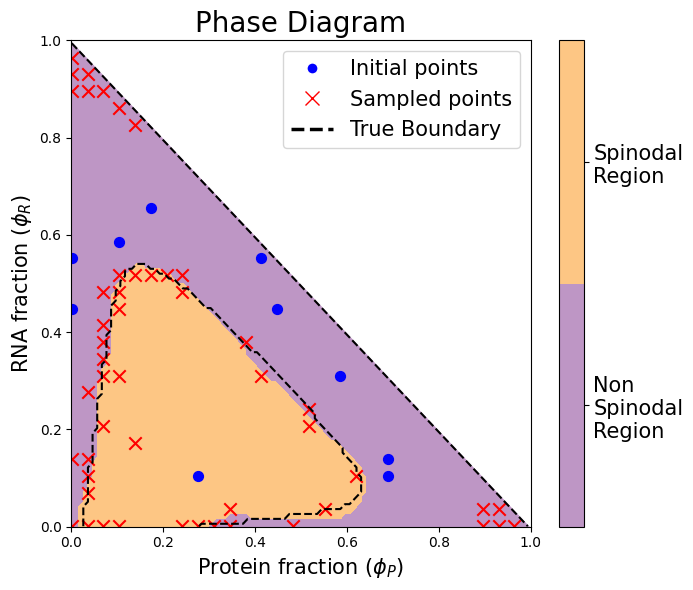

In [14]:
draw_diagram_and_boundary(multi_tl_model, multi_tl_sampled_points, figsize = (7,6), plot_type="phase")

### Plot the Probability diagram

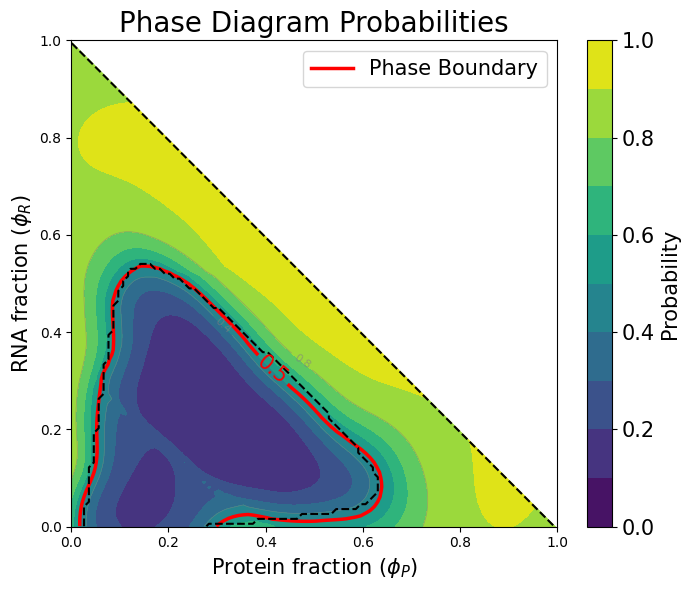

In [15]:
draw_diagram_and_boundary(multi_tl_model, multi_tl_sampled_points, figsize = (7,6), plot_type="probability", plot_boundary=False)

### Plot the Acquisition values

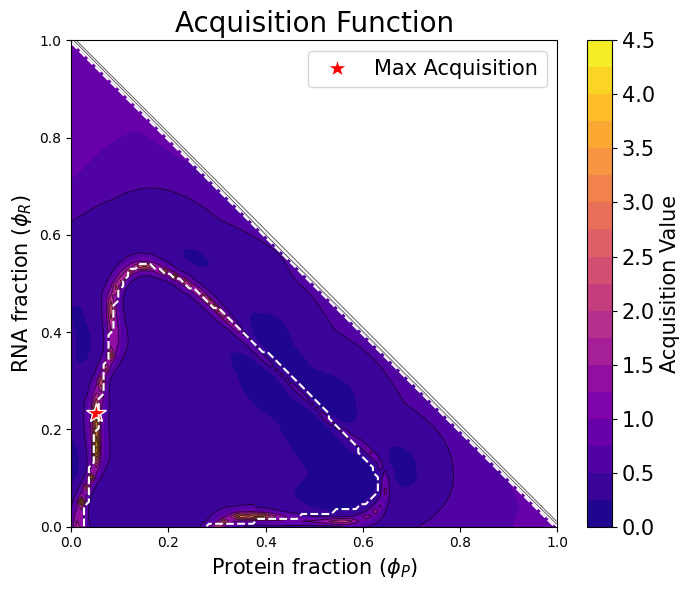

In [16]:
draw_diagram_and_boundary(multi_tl_model, multi_tl_sampled_points, figsize = (7,6), plot_type="acquisition")

### Plot the weights

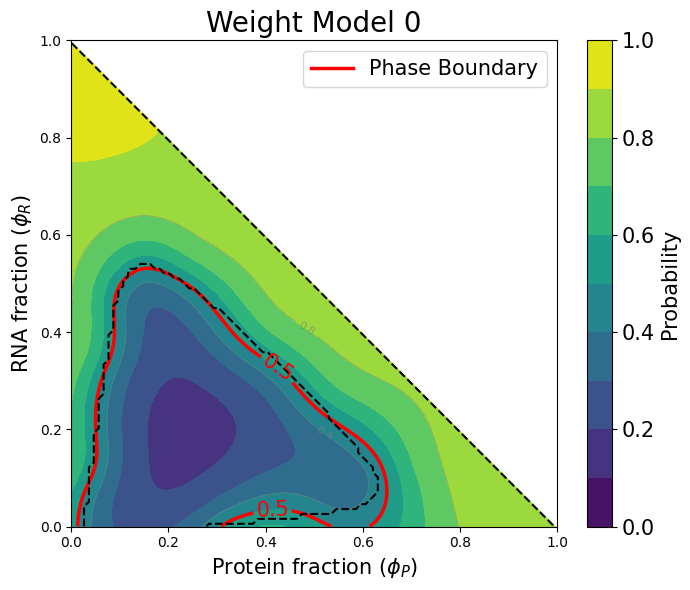

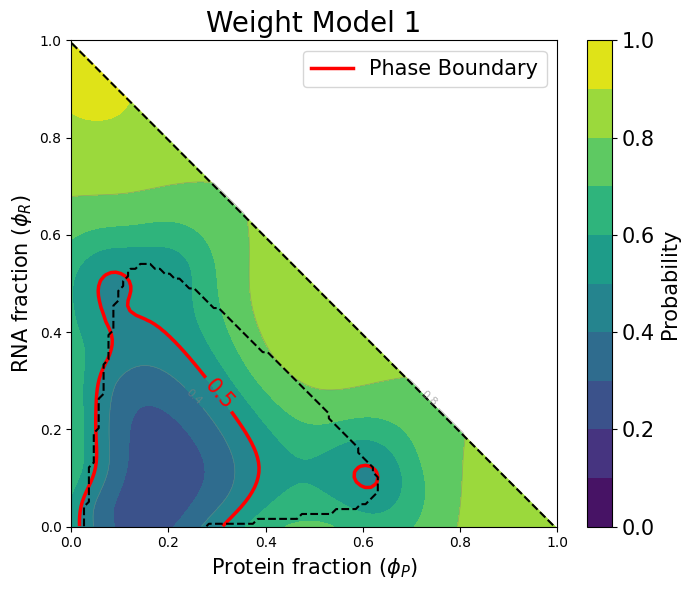

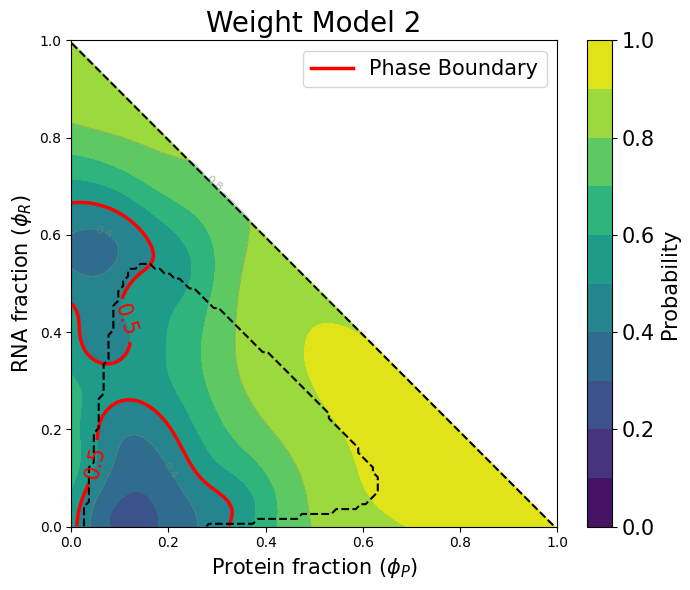

In [17]:
for i, weight_model in enumerate(multi_tl_model.weight_model_list):
    draw_diagram_and_boundary(weight_model, figsize = (7,6), plot_type="probability", plot_boundary=True, title=f"Weight Model {i}")

# Error Curves Results

Vanilla acc: 0.02606060542166233
First under 0.1 error: 15
First under 0.05 error: 22
----------------------
Single Source
PhaseTransfer acc: 0.016565656289458275
First under 0.1 error: 0
First under 0.05 error: 22
----------------------
Multi Source
PhaseTransfer acc: 0.02606060542166233
First under 0.1 error: 8
First under 0.05 error: 10
----------------------
----------------------


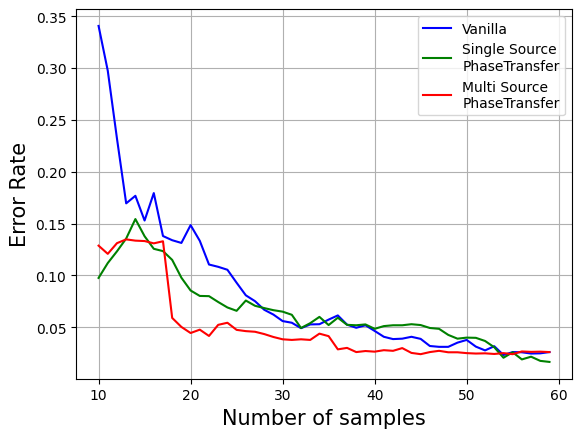

In [18]:

acc_threshold = 0.05


label = ["Vanilla", "Single Source\nPhaseTransfer", "Multi Source\nPhaseTransfer"]
color = ["blue", "green", "red", "aqua"]
error_curves = [np.array(vanilla_error_curve), np.array(tl_single_error_curve), np.array(multi_tl_error_curve)]
points = np.arange(len(vanilla_error_curve))

for i, error_curve in enumerate(error_curves):
    plt.plot(points+10, error_curve, label=label[i], color=color[i])
    plt.legend(fontsize = 10)

    first_index = np.argmax(error_curve < acc_threshold*2) if np.any(error_curve< acc_threshold*2) else -1
    print(f"{label[i]} acc: {error_curve[-1]}")
    print(f"First under {acc_threshold*2} error: {first_index}")
    first_index = np.argmax(error_curve < acc_threshold) if np.any(error_curve < acc_threshold) else -1
    print(f"First under {acc_threshold} error: {first_index}")
    print("----------------------")

print("----------------------")
plt.xlabel("Number of samples", fontsize=15)
plt.ylabel("Error Rate", fontsize=15)
plt.grid()
plt.show()
  